# Generacion de libros de codificacion
---

## Diagrama de la estructura de clasificacion y entrenamiento de vectores cuantizados
 
 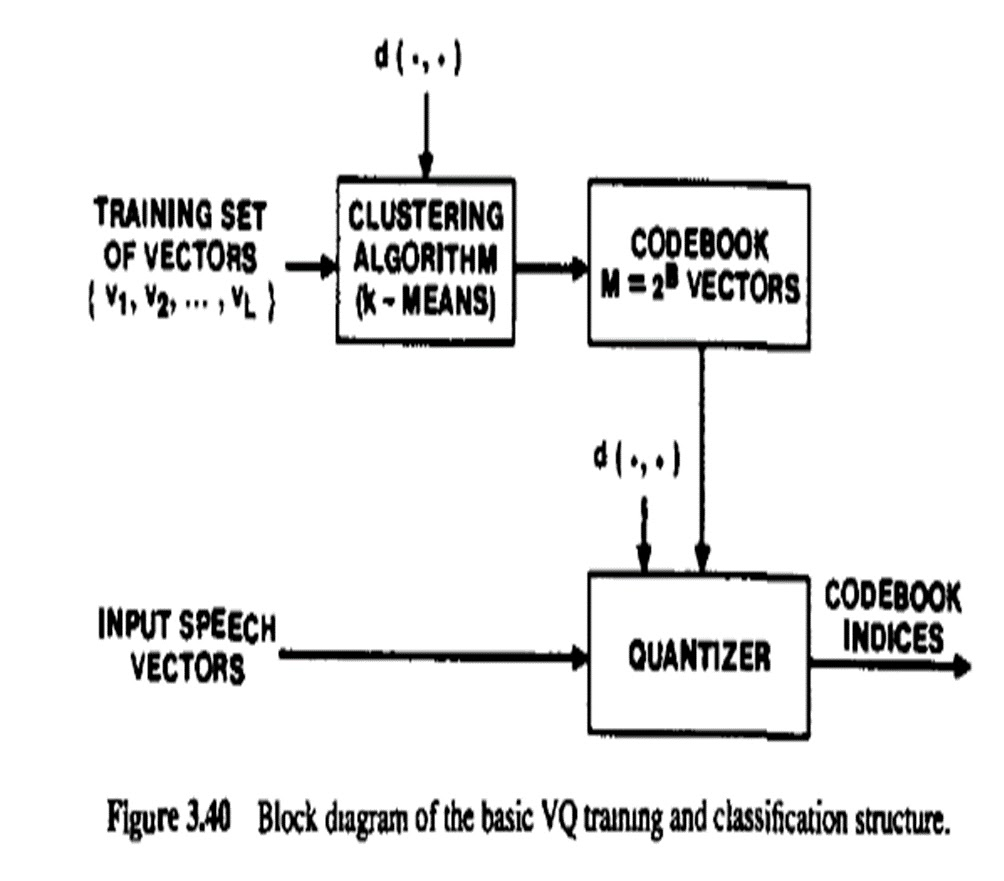


## Creacion de clusters con distribuciones normales (Bajo etiqueta)

In [1]:
import numpy as np
import math
from functools import reduce
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm


In [12]:
SEEDS = [2, 3, 5, 7, 11, 13, 17, 19]
n_clusters = 5
total_dimensions = 10

In [13]:
# Uso de centros encontrados aleatoriamente para usar distribuciones normales para generar los siguientes vectores
means = []
for i in range(n_clusters):
    means.append(np.random.uniform(-1, 1, total_dimensions))
means


[array([-0.06709583, -0.88667795, -0.20221778, -0.45148203, -0.6643235 ,
        -0.46319055,  0.23664529, -0.05852873,  0.70771878,  0.49279505]),
 array([ 0.68708599,  0.20226601,  0.18341327, -0.74774812,  0.7650987 ,
        -0.72129978,  0.38652165, -0.57582887,  0.69081952, -0.24632298]),
 array([ 0.21961584,  0.32946061, -0.28203499,  0.87257955,  0.65850824,
         0.08164077,  0.7114203 , -0.84075668, -0.29299919, -0.90732728]),
 array([-0.75617772,  0.00696958,  0.07589178, -0.63077489, -0.46553668,
        -0.96833742,  0.90382793,  0.13985309, -0.9315108 , -0.77525297]),
 array([-0.96221021, -0.77645774,  0.79608056,  0.93436572,  0.77839736,
        -0.44553726,  0.82248796, -0.77371714,  0.24664329,  0.86172873])]

In [14]:
desviation = 0.2
clusters = []
for i,mean in enumerate(means):
    np.random.seed(SEEDS[i])
    vectors = []
    for _ in range(np.random.randint(40,100)):
        vector = []
        for dimension in range(total_dimensions):
            vector.append(np.random.normal(loc = mean[dimension], scale = desviation))

        vectors.append(np.array(vector))

    clusters.append(np.array(vectors))


In [ ]:
def plot_2_dimensions(d_1, d_2, vectors):
    n_clusters = len(vectors)
    colors = cm.rainbow(np.linspace(0, 1, n_clusters))

    for i in range(n_clusters):
        x = vectors[i][:, d_1]
        y = vectors[i][:, d_2]
        plt.scatter(x,y, color = colors[i], label=f"Cluster {i+1}")

    plt.title(f"Gradica de dimension: {d_1} vs {d_2}")
    plt.xlabel(f"{d_1}")
    plt.legend()
    plt.ylabel(f"{d_2}")
    plt.show()
    

#### Clusters generados:

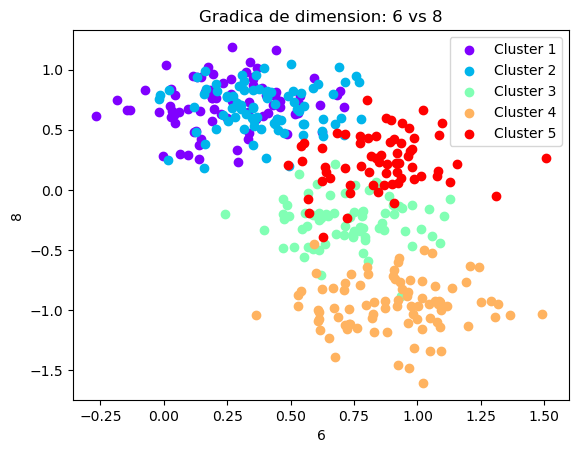

In [15]:
plot_2_dimensions(6, 8, clusters)

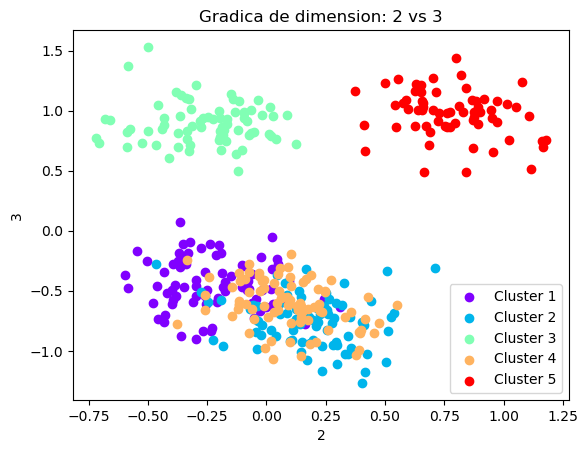

In [16]:
plot_2_dimensions(2, 3, clusters)

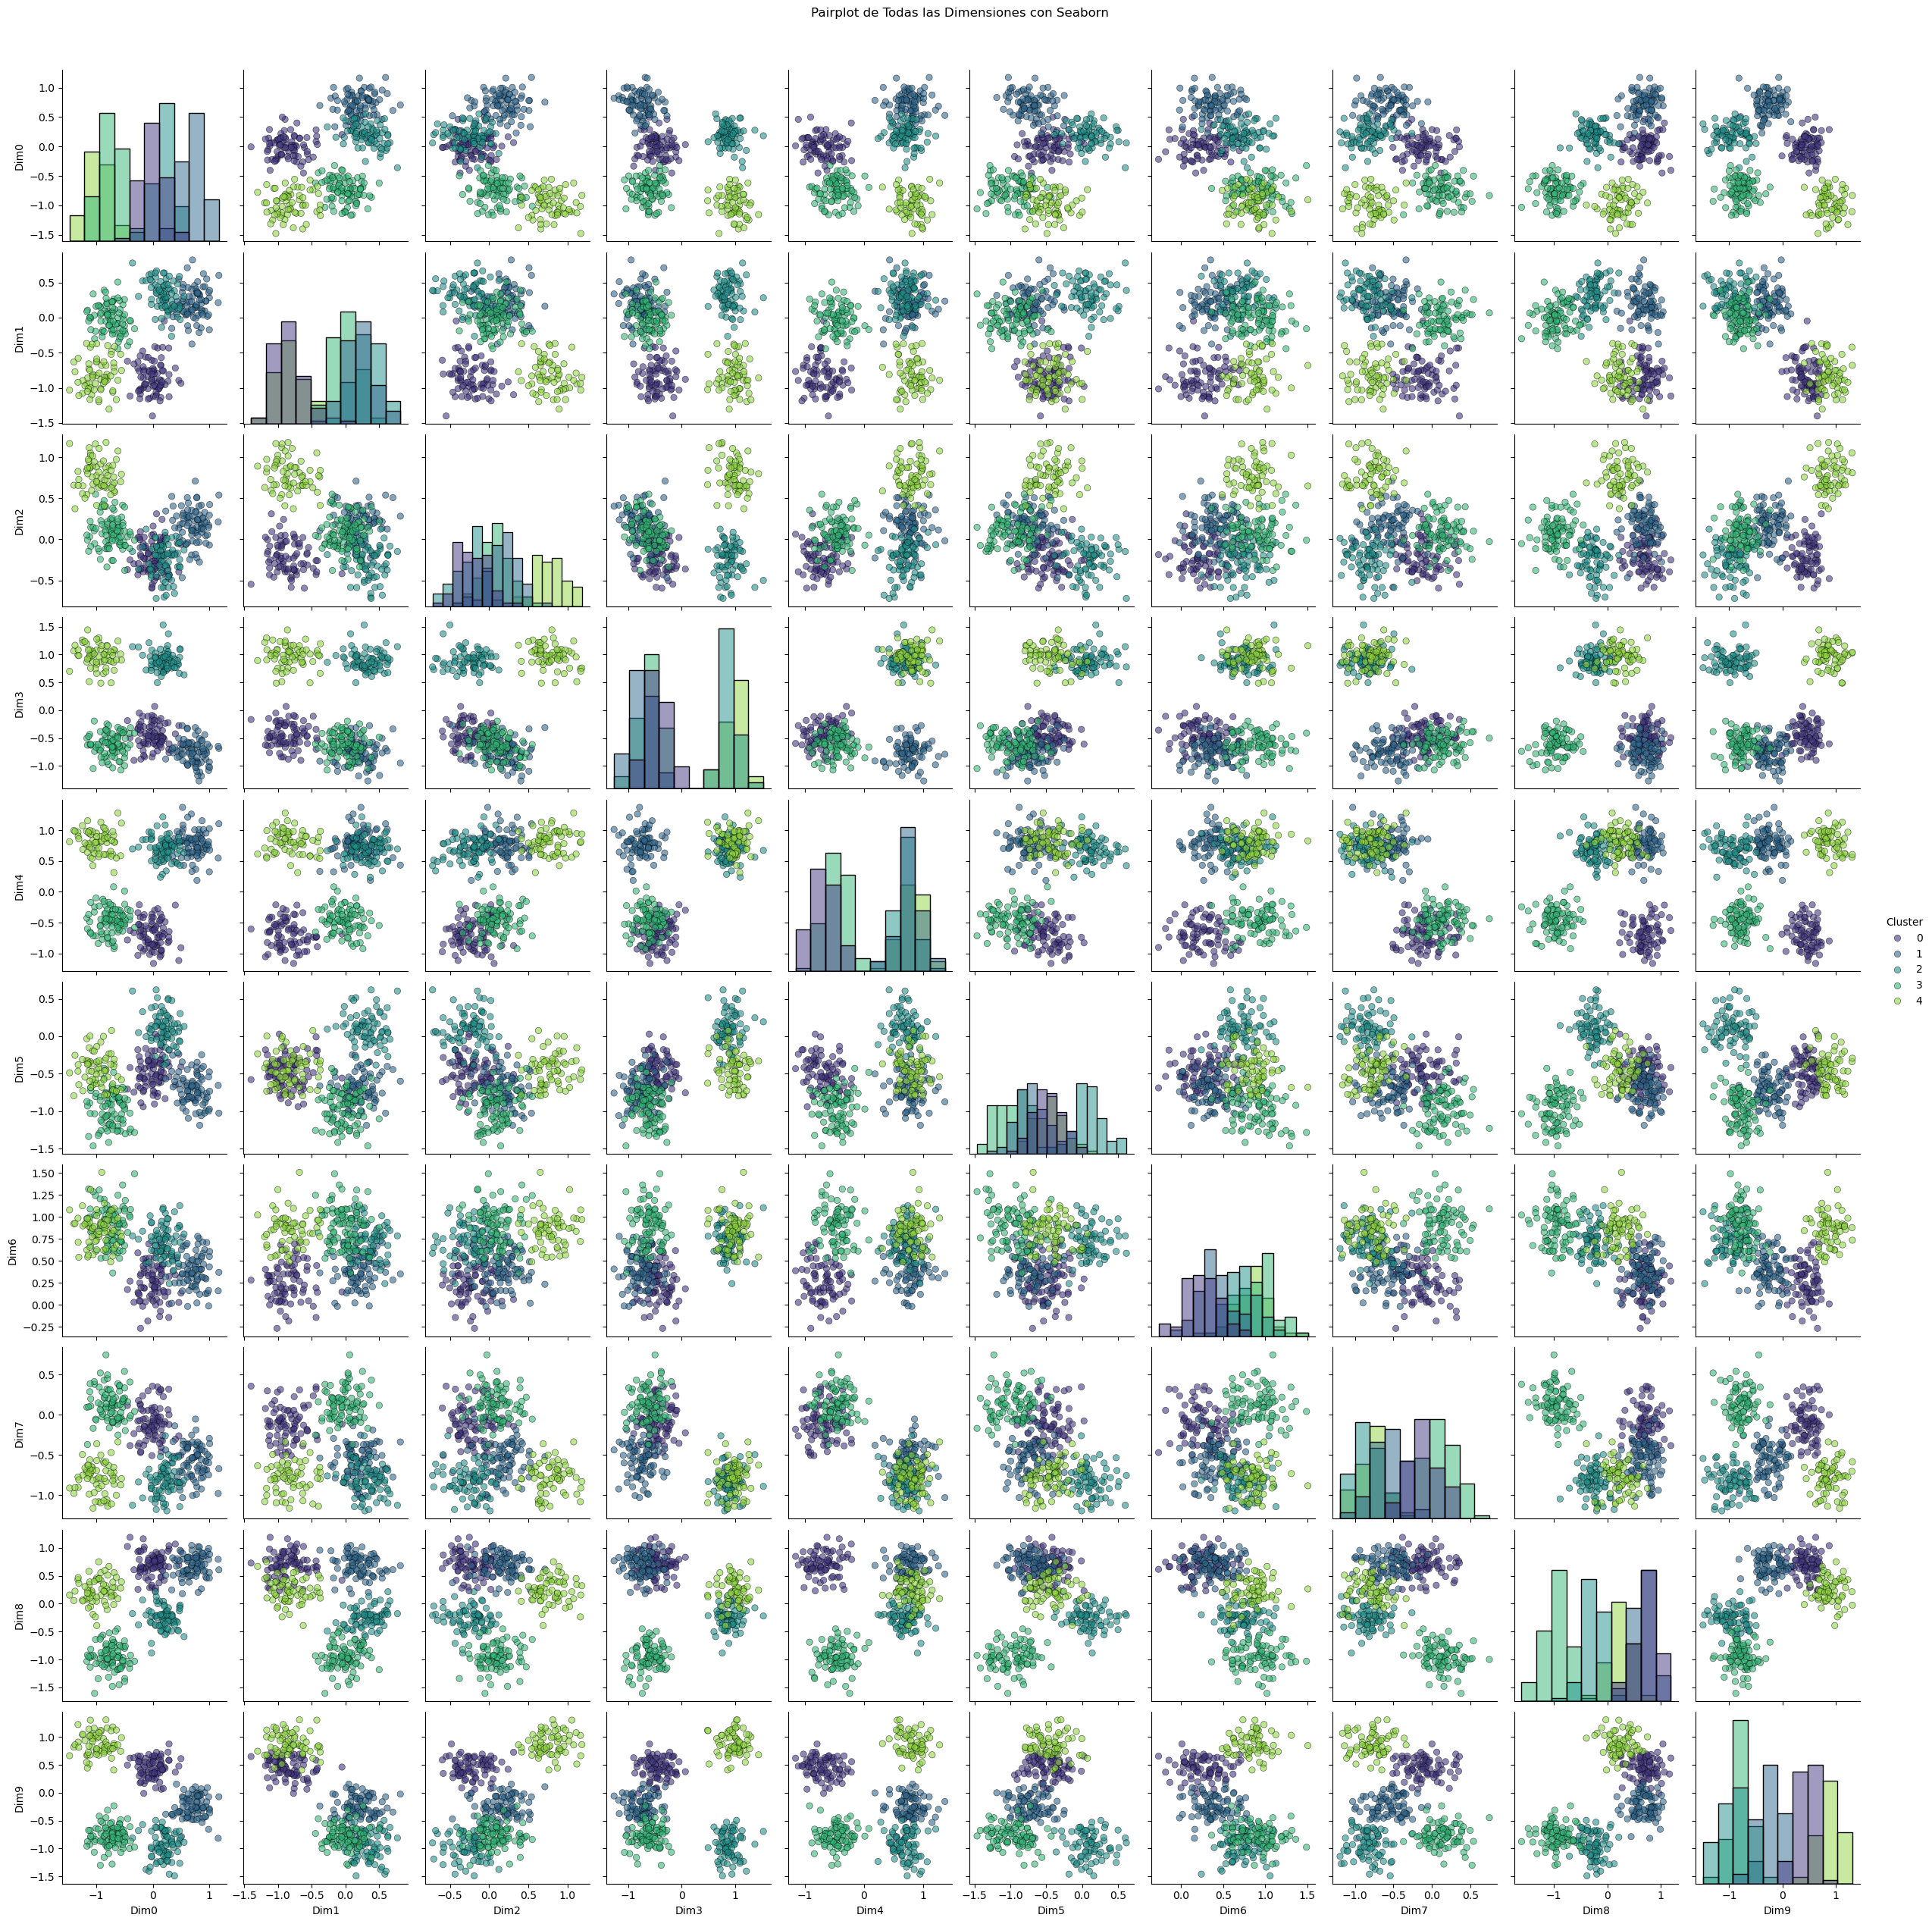

In [17]:
import seaborn as sns
import pandas as pd

# Supongamos que tus datos están concatenados y etiquetados
# Convertir a DataFrame
datos = np.vstack(clusters)
etiquetas = np.hstack([[i] * len(cluster) for i, cluster in enumerate(clusters)])
df = pd.DataFrame(datos, columns=[f'Dim{d}' for d in range(total_dimensions)])
df['Cluster'] = etiquetas.astype(str)  # Convertir a string para hue

# Crear pairplot
sns.pairplot(df, hue='Cluster', palette='viridis', diag_kind='hist', markers='o', plot_kws={'alpha':0.6, 'edgecolor':'k'})
plt.suptitle('Pairplot de Todas las Dimensiones con Seaborn', y=1.02)
plt.show()


## Creacion de libros de codificacion
### Funcion de entrenamiento (Algoritmo LBG):
El algoritmo LBG (Linde-Buzo-Gray) es un método fundamental en el campo de la cuantización vectorial, ampliamente utilizado en compresión de señales y procesamiento de imágenes. Fue desarrollado por David Linde, Peter Buzo y Robert Gray en 1980 y se ha convertido en una técnica estándar para diseñar códigos de cuántización eficientes.

#### ¿Qué es la Cuantización Vectorial?
Antes de profundizar en el algoritmo LBG, es importante entender qué es la cuantización vectorial:

Cuantización: Proceso de mapear un conjunto continuo de valores a un conjunto finito de niveles discretos. Es esencial en la compresión de datos para reducir la cantidad de información necesaria para representar una señal.

Cuantización Vectorial: Extiende la cuantización a vectores en lugar de valores escalares. Esto permite capturar mejor las correlaciones entre múltiples dimensiones de los datos, mejorando la eficiencia de la compresión.

#### Objetivo del Algoritmo LBG
El principal objetivo del algoritmo LBG es diseñar un código de cuántización (un conjunto de vectores de referencia llamados "códigos") que minimice el error de cuantización para un conjunto dado de datos. Es decir, busca encontrar los mejores representantes para agrupar los datos de manera que la distancia (error) entre los datos y sus representantes sea la menor posible.


#### Seudocodigo
 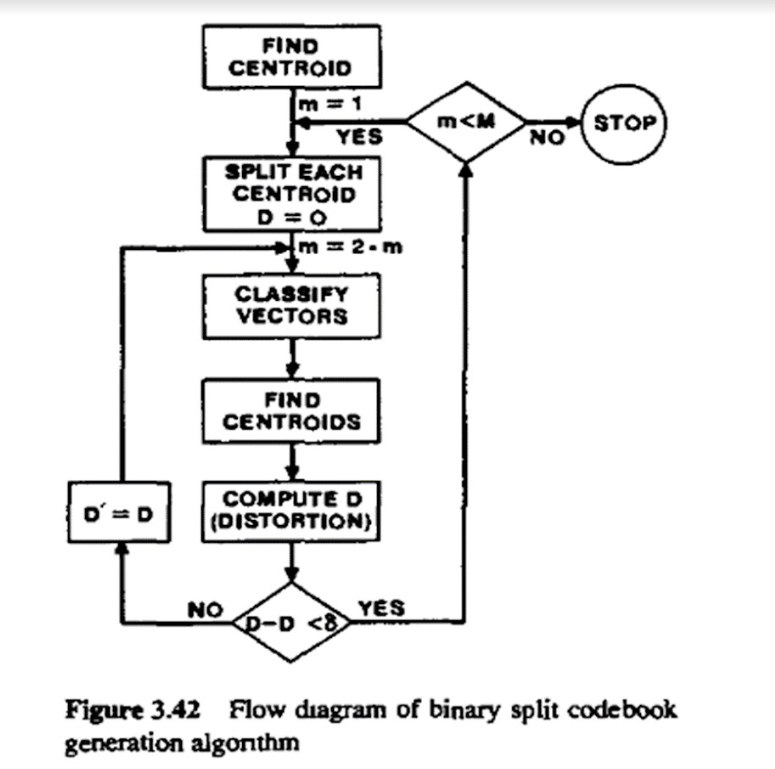
Fuente: https://github.com/internaut/py-lbg

In [18]:
def find_centroids(vecs, dim=None, size=None):
    """
    Calculcate average vector (center vector) for input vectors <vecs>.
    :param vecs: input vectors
    :param dim: dimension of <vecs> if it was already calculated
    :param size: size of <vecs> if it was already calculated
    :return average vector (center vector) for input vectors <vecs>
    """
    size = size or len(vecs)
    dim = dim or len(vecs[0])
    avg_vec = [0.0] * dim
    for vec in vecs:
        for i, x in enumerate(vec):
            avg_vec[i] += x / size

    return avg_vec
def new_codevector(c, e):
    """
    Create a new codevector based on <c> but moved by factor <e>
    :param c: base codevector
    :param e: move factor
    :return new codevector
    """
    return [x * (1.0 + e) for x in c]


def avg_distortion_c0(c0, data, size=None):
    """
    Average distortion of <c0> in relation to <data> (i.e. how good does <c0> describe <data>?).
    :param c0: comparison vector
    :param data: sample data
    :param size: size of <data> if it was already calculated
    :return average distortion
    """
    size = size or _size_data
    return reduce(lambda s, d:  s + d / size,
                  (euclid_squared(c0, vec)
                   for vec in data),
                  0.0)


def avg_distortion_c_list(c_list, data, size=None):
    """
    Average distortion between input samples <data> and a list <c_list> that contains a codevector for each point in
    <data>.
    :param c_list: list that contains a codevector for each point in <data>
    :param data: input samples
    :param size: Size of <data> if it was already calculated
    :return:
    """
    size = size or _size_data
    return reduce(lambda s, d:  s + d / size,
                  (euclid_squared(c_i, data[i])
                   for i, c_i in enumerate(c_list)),
                  0.0)


def euclid_squared(a, b):
    return sum((x_a - x_b) ** 2 for x_a, x_b in zip(a, b))


def split_codebook(data, codebook, epsilon, initial_avg_dist):
    """
    Split the codebook so that each codevector in the codebook is split into two.
    :param data: input data
    :param codebook: input codebook. its codevectors will be split into two.
    :param epsilon: convergence value
    :param initial_avg_dist: initial average distortion
    :return Tuple with new codebook, codebook absolute weights and codebook relative weights
    """

    # split codevectors
    new_codevectors = []
    for c in codebook:
        # the new codevectors c1 and c2 will moved by epsilon and -epsilon so to be apart from each other
        c1 = new_codevector(c, epsilon)
        c2 = new_codevector(c, -epsilon)
        new_codevectors.extend((c1, c2))

    codebook = new_codevectors
    len_codebook = len(codebook)
    abs_weights = [0] * len_codebook
    rel_weights = [0.0] * len_codebook

    # print('> splitting to size', len_codebook)

    # try to reach a convergence by minimizing the average distortion. this is done by moving the codevectors step by
    # step to the center of the points in their proximity
    avg_dist = 0
    err = epsilon + 1
    num_iter = 0
    while err > epsilon:
        # find closest codevectors for each vector in data (find the proximity of each codevector)
        closest_c_list = [None] * _size_data    # list that contains the nearest codevector for each input data vector
        vecs_near_c = defaultdict(list)         # list with codevector index -> input data vector mapping
        vec_idxs_near_c = defaultdict(list)     # list with codevector index -> input data index mapping
        for i, vec in enumerate(data):  # for each input vector
            min_dist = None
            closest_c_index = None
            for i_c, c in enumerate(codebook):  # for each codevector
                d = euclid_squared(vec, c)
                if min_dist is None or d < min_dist:    # found new closest codevector
                    min_dist = d
                    closest_c_list[i] = c
                    closest_c_index = i_c
            vecs_near_c[closest_c_index].append(vec)
            vec_idxs_near_c[closest_c_index].append(i)

        # update codebook: recalculate each codevector so that it sits in the center of the points in their proximity
        for i_c in range(len_codebook): # for each codevector index
            vecs = vecs_near_c.get(i_c) or []   # get its proximity input vectors
            num_vecs_near_c = len(vecs)
            if num_vecs_near_c > 0:
                new_c = find_centroids(vecs, _dim)     # calculate the new center
                codebook[i_c] = new_c                   # update in codebook
                for i in vec_idxs_near_c[i_c]:          # update in input vector index -> codevector mapping list
                    closest_c_list[i] = new_c

                # update the weights
                abs_weights[i_c] = num_vecs_near_c
                rel_weights[i_c] = num_vecs_near_c / _size_data

        # recalculate average distortion value
        prev_avg_dist = avg_dist if avg_dist > 0 else initial_avg_dist
        avg_dist = avg_distortion_c_list(closest_c_list, data)

        # recalculate the new error value
        err = (prev_avg_dist - avg_dist) / prev_avg_dist
        # print(closest_c_list)
        # print('> iteration', num_iter, 'avg_dist', avg_dist, 'prev_avg_dist', prev_avg_dist, 'err', err)

        num_iter += 1

    return codebook, abs_weights, rel_weights, avg_dist


def generate_codebook(data, size_codebook, epsilon=0.00001):
    """
    Generate codebook of size <size_codebook> with convergence value <epsilon>. Will return a tuple with the
    generated codebook, a vector with absolute weights and a vector with relative weights (the weight denotes how many
    vectors for <data> are in the proximity of the codevector.
    :param data: input data with N k-dimensional vectors
    :param size_codebook: codebook size. Because the codevectors are split on each iteration, this should be a
                          power-of-2-value
    :param epsilon: convergence value
    :return tuple of: codebook of size <size_codebook>, absolute weights, relative weights
    """
    global _size_data, _dim

    _size_data = len(data)
    assert _size_data > 0

    _dim = len(data[0])
    assert _dim > 0

    codebook = []
    codebook_abs_weights = [_size_data]
    codebook_rel_weights = [1.0]

    # calculate initial codevector: average vector of whole input data
    c0 = find_centroids(data, _dim, _size_data)
    codebook.append(c0)

    # calculate the average distortion
    avg_dist = avg_distortion_c0(c0, data)

    # split codevectors until we have have enough
    while len(codebook) < size_codebook:
        codebook, codebook_abs_weights, codebook_rel_weights, avg_dist = split_codebook(data, codebook,
                                                                                        epsilon, avg_dist)

    return codebook, codebook_abs_weights, codebook_rel_weights


In [21]:
vectors_Q = []
for cluster in clusters:
    for vector in cluster:
        vectors_Q.append(vector)

In [22]:
codebooks, absolute_weights, relative_weights = generate_codebook(vectors_Q, 5)

#### Vector mas representativo del libro de codificacion:

In [23]:
codebooks

[[-1.038453899103117,
  -0.943537433139697,
  0.8137227992358788,
  1.0076646066895907,
  0.8557125357751818,
  -0.5020709536467565,
  0.8696509262695492,
  -0.8209067100446877,
  0.24989512798527286,
  0.8976267193667539],
 [-0.8766835962258038,
  -0.6428243612432968,
  0.738172574062504,
  0.9204855045832,
  0.7565927111715296,
  -0.3499572181552667,
  0.8376410613089509,
  -0.7323522635398505,
  0.21177256757658225,
  0.8505333793595288],
 [-0.7461095820774988,
  -0.009717021871362055,
  0.08895534223414044,
  -0.6120402042424553,
  -0.46108940238323737,
  -0.9709212546790865,
  0.9076386895925539,
  0.1347472909094469,
  -0.9579751699611747,
  -0.7745613983756467],
 [0.19033295480838697,
  0.32230827992685157,
  -0.257624149673391,
  0.8903903390786898,
  0.6951884950049176,
  0.10735410104956968,
  0.7291246166000324,
  -0.8291652205829402,
  -0.2598623688647719,
  -0.9479767048898765],
 [0.7810098273353736,
  0.146893377027291,
  0.1494241586442615,
  -0.8260748587831941,
  0.831

In [24]:
relative_weights

[0.10025706940874037,
 0.06683804627249357,
 0.2236503856041131,
 0.1928020565552699,
 0.10282776349614396,
 0.10796915167095116,
 0.10282776349614396,
 0.10282776349614396]

In [25]:
absolute_weights

[39, 26, 87, 75, 40, 42, 40, 40]

Son 6 vectores debido a que los clusters de LBG son pares por el factor de division en dos